In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [3]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

def concatenate_mini_batches_feat_orien(batch_result):
    mini_feat_batch_concat = []
    mini_orien_batch_concat = []
    
    for i, (boxs, mini_feat_batch, mini_orien_batch) in enumerate(batch_result):
        mini_feat_batch_concat.append(mini_feat_batch)
        mini_orien_batch_concat.append(mini_orien_batch)

    mini_feat_batch_concat = torch.cat(mini_feat_batch_concat, dim=0)
    mini_orien_batch_concat = torch.cat(mini_orien_batch_concat, dim=0)

    mini_dataloader = torch.stack([mini_feat_batch_concat, mini_orien_batch_concat], dim=1)

    return mini_dataloader


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 100 loss 3.5150668924930053
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

mini_dataloader  torch.Size([1239, 2, 31, 31])


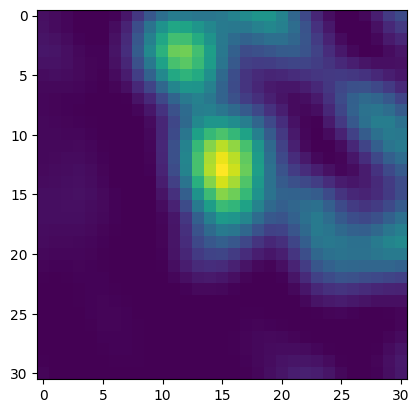

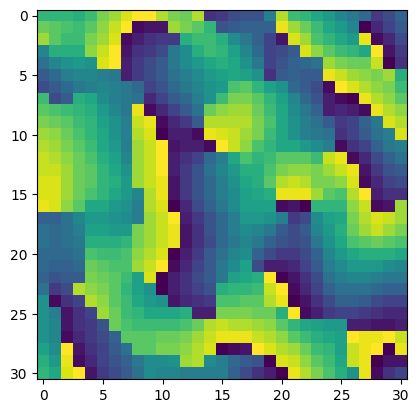

In [4]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

mini_dataloader = concatenate_mini_batches_feat_orien(batch_result)
print('mini_dataloader ',mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [5]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 25

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.6
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


30
20


### Define arquitetura do modelo de rede siamesa

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [7]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 128)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        # Calculando a diferença entre os embeddings
        # diff = flatten_x1 - flatten_x2
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x


### Metodos para o processo de treinamento

In [8]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.8
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=(-180., 180.),translate=None,scale=None)(x)
    return x


In [9]:
model =Siamesa(n_dim=31,n_channel=2).to(device)
X1=torch.rand(8,2,31,31).to(device)
X2=torch.rand(8,2,31,31).to(device)
model(X1,X1)

tensor([0.9993, 0.9978, 0.9984, 0.9988, 0.9986, 0.9980, 0.9977, 0.9949],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [10]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        if (epoch % 15 == 0) and (epoch != 0):
            scheduler.step()
        print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=70,device=device)

Tests : 100%|██████████| 20/20 [00:00<00:00, 49.88it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 0, Train Loss: 0.7907, Test Loss: 0.7749


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.08it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 1, Train Loss: 0.7507, Test Loss: 0.7370


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.07it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 2, Train Loss: 0.7140, Test Loss: 0.6940


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.45it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 3, Train Loss: 0.6859, Test Loss: 0.6822


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.05it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 4, Train Loss: 0.6692, Test Loss: 0.6639


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.36it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 5, Train Loss: 0.6518, Test Loss: 0.6438


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.41it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 6, Train Loss: 0.6288, Test Loss: 0.6312


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.84it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 7, Train Loss: 0.6153, Test Loss: 0.6124


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.33it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 8, Train Loss: 0.6016, Test Loss: 0.6294


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.89it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 9, Train Loss: 0.6042, Test Loss: 0.5966


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.55it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 10, Train Loss: 0.5925, Test Loss: 0.6052


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.75it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 11, Train Loss: 0.5895, Test Loss: 0.5867


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.11it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 12, Train Loss: 0.5872, Test Loss: 0.5797


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.26it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 13, Train Loss: 0.5693, Test Loss: 0.5624


Tests : 100%|██████████| 20/20 [00:00<00:00, 48.95it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 14, Train Loss: 0.5655, Test Loss: 0.5539


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.26it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 15, Train Loss: 0.5530, Test Loss: 0.5480


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.72it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 16, Train Loss: 0.5367, Test Loss: 0.5310


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.93it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 17, Train Loss: 0.5294, Test Loss: 0.5334


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.83it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 18, Train Loss: 0.5316, Test Loss: 0.5240


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.96it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 19, Train Loss: 0.5141, Test Loss: 0.5030


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.25it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 20, Train Loss: 0.5005, Test Loss: 0.5051


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.66it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 21, Train Loss: 0.4876, Test Loss: 0.4876


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.00it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 22, Train Loss: 0.4760, Test Loss: 0.4797


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.65it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 23, Train Loss: 0.4716, Test Loss: 0.4554


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.84it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 24, Train Loss: 0.4613, Test Loss: 0.4470


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.88it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 25, Train Loss: 0.4608, Test Loss: 0.4808


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.34it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 26, Train Loss: 0.4592, Test Loss: 0.4420


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.17it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 27, Train Loss: 0.4589, Test Loss: 0.4426


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.45it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 28, Train Loss: 0.4478, Test Loss: 0.4687


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.31it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 29, Train Loss: 0.4427, Test Loss: 0.4334


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.23it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 30, Train Loss: 0.4383, Test Loss: 0.4375


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.52it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 31, Train Loss: 0.4432, Test Loss: 0.4777


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.93it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 32, Train Loss: 0.4509, Test Loss: 0.4394


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.48it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 33, Train Loss: 0.4280, Test Loss: 0.4434


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.66it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 34, Train Loss: 0.4362, Test Loss: 0.4341


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.68it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 35, Train Loss: 0.4362, Test Loss: 0.4262


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.92it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 36, Train Loss: 0.4319, Test Loss: 0.4356


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.22it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 37, Train Loss: 0.4288, Test Loss: 0.4132


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.46it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 38, Train Loss: 0.4236, Test Loss: 0.4115


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.64it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 39, Train Loss: 0.4229, Test Loss: 0.4256


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.39it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 40, Train Loss: 0.4107, Test Loss: 0.4091


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.48it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 41, Train Loss: 0.4191, Test Loss: 0.4123


Tests : 100%|██████████| 20/20 [00:00<00:00, 54.28it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 42, Train Loss: 0.4189, Test Loss: 0.4184


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.06it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 43, Train Loss: 0.4154, Test Loss: 0.4034


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.43it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 44, Train Loss: 0.4149, Test Loss: 0.4097


Tests : 100%|██████████| 20/20 [00:00<00:00, 54.15it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 45, Train Loss: 0.4221, Test Loss: 0.4335


Tests : 100%|██████████| 20/20 [00:00<00:00, 49.12it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 46, Train Loss: 0.4220, Test Loss: 0.4073


Tests : 100%|██████████| 20/20 [00:00<00:00, 46.47it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 47, Train Loss: 0.4111, Test Loss: 0.4235


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.01it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 48, Train Loss: 0.4098, Test Loss: 0.4223


Tests : 100%|██████████| 20/20 [00:00<00:00, 49.83it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 49, Train Loss: 0.4072, Test Loss: 0.4133


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.24it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 50, Train Loss: 0.4096, Test Loss: 0.4075


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.77it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 51, Train Loss: 0.4069, Test Loss: 0.4103


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.40it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 52, Train Loss: 0.4070, Test Loss: 0.4116


Tests : 100%|██████████| 20/20 [00:00<00:00, 56.17it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 53, Train Loss: 0.4053, Test Loss: 0.4045


Tests : 100%|██████████| 20/20 [00:00<00:00, 48.93it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 54, Train Loss: 0.4132, Test Loss: 0.4400


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.20it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 55, Train Loss: 0.4090, Test Loss: 0.4190


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.68it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 56, Train Loss: 0.4018, Test Loss: 0.3947


Tests : 100%|██████████| 20/20 [00:00<00:00, 53.37it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 57, Train Loss: 0.4048, Test Loss: 0.3935


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.42it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 58, Train Loss: 0.4147, Test Loss: 0.3999


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.42it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 59, Train Loss: 0.4030, Test Loss: 0.4127


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.25it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 60, Train Loss: 0.4020, Test Loss: 0.4372


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.78it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 61, Train Loss: 0.4125, Test Loss: 0.3911


Tests : 100%|██████████| 20/20 [00:00<00:00, 45.83it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 62, Train Loss: 0.4039, Test Loss: 0.4018


Tests : 100%|██████████| 20/20 [00:00<00:00, 47.49it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 63, Train Loss: 0.4002, Test Loss: 0.3912


Tests : 100%|██████████| 20/20 [00:00<00:00, 49.25it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 64, Train Loss: 0.3997, Test Loss: 0.3947


Tests : 100%|██████████| 20/20 [00:00<00:00, 50.17it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 65, Train Loss: 0.3975, Test Loss: 0.3980


Tests : 100%|██████████| 20/20 [00:00<00:00, 52.64it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 66, Train Loss: 0.3993, Test Loss: 0.3971


Tests : 100%|██████████| 20/20 [00:00<00:00, 46.70it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 67, Train Loss: 0.3929, Test Loss: 0.3914


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.42it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 68, Train Loss: 0.3995, Test Loss: 0.3904


Tests : 100%|██████████| 20/20 [00:00<00:00, 51.23it/s]


initial_lr  0.0001 lr  3.1640625e-05
Epoch: 69, Train Loss: 0.4027, Test Loss: 0.4054


### Teste com a rede siamesa

In [11]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [12]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


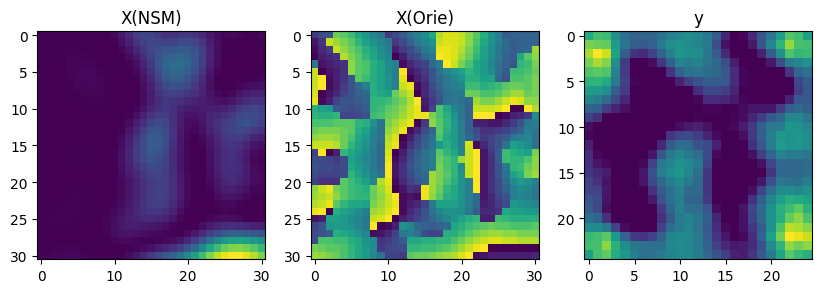

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.6384, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4714, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3284, device='cuda:0') tensor(0.8903, device='cuda:0')


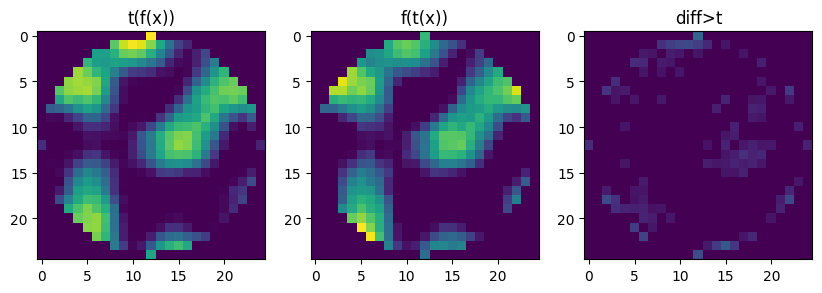

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5043, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4841, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2235, device='cuda:0') tensor(0.8746, device='cuda:0')


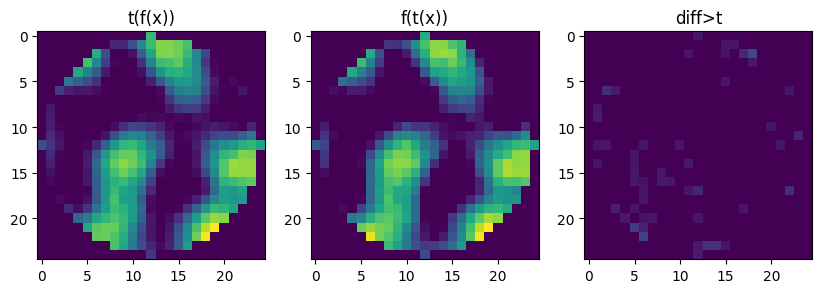

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5415, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5263, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1242, device='cuda:0') tensor(0.7544, device='cuda:0')


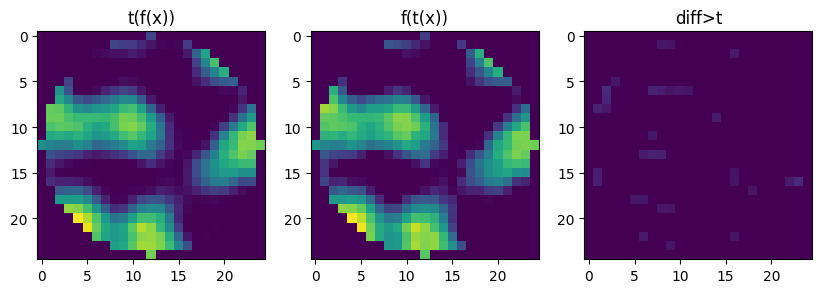

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4977, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5809, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3916, device='cuda:0') tensor(0.8666, device='cuda:0')


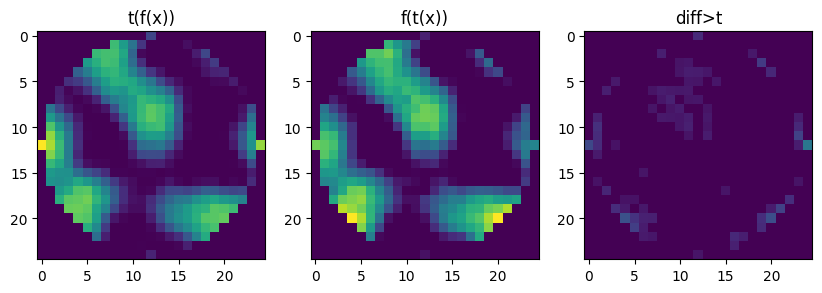

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5222, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4825, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2297, device='cuda:0') tensor(0.8602, device='cuda:0')


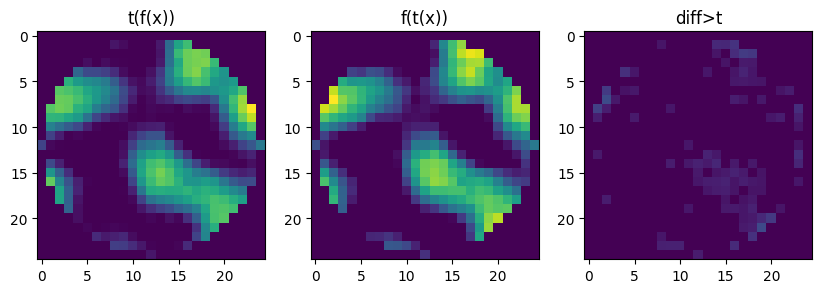

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5222, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4825, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2297, device='cuda:0') tensor(0.8602, device='cuda:0')


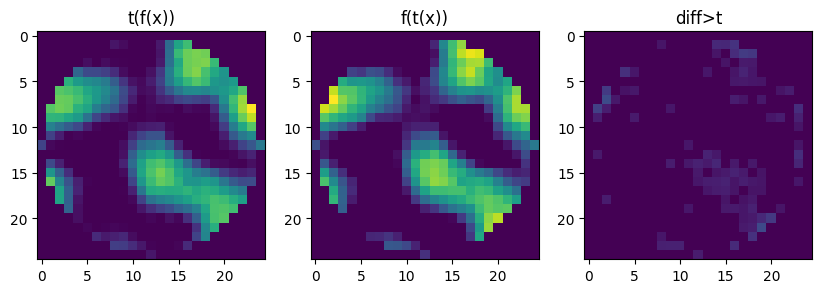

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5200, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4818, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2789, device='cuda:0') tensor(0.8533, device='cuda:0')


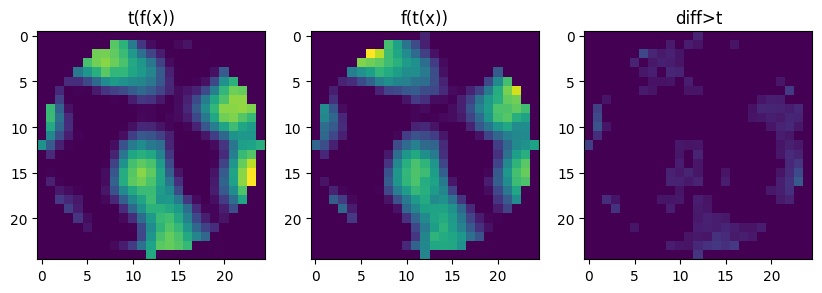

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5839, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.4744, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2924, device='cuda:0') tensor(0.8961, device='cuda:0')


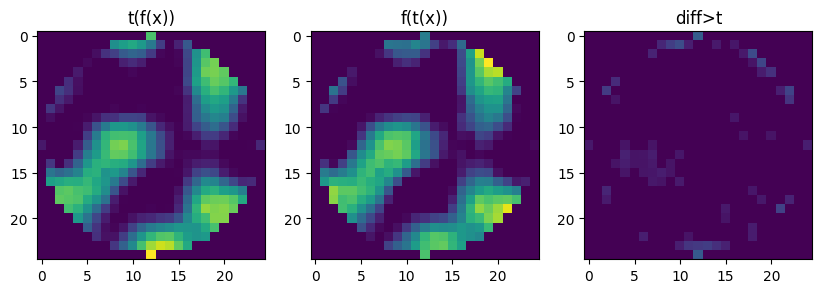

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5209, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5589, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3833, device='cuda:0') tensor(0.8601, device='cuda:0')


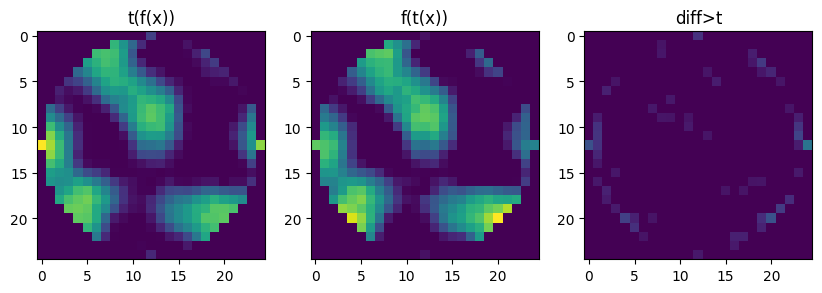

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5713, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.5079, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2114, device='cuda:0') tensor(0.8744, device='cuda:0')


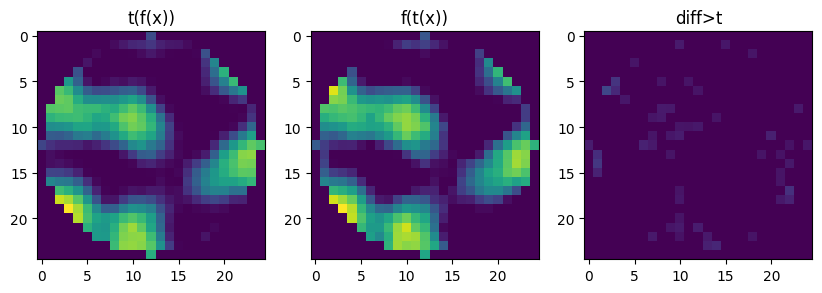

In [13]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)



iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[index,0])
        y2n=normalize_tensor(y_rotated2[index,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [14]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []

    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)
            if apply_random_transform:
                data_temp = random_transform(data_temp)

            distances = model(data1, data_temp)
            match_index = distances.argmin().item()

            matches.append((i, match_index))

    return np.array(matches)

            

matching_results = matching_single_points(data, data, apply_random_transform=True)
print('matching pair ',matching_results)


# for (i,j) in matching_results[:10]:
#     print('i ',i,' j ',j)
#     plot_pair_image(data[i,0],data2[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

matching pair  [[ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 7  7]
 [ 8  8]
 [ 9  9]
 [10 10]
 [11 11]
 [12 12]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [17 17]
 [18 18]
 [19 19]
 [20 20]
 [21 21]
 [22 22]
 [23 23]
 [24 24]]


### Comparar features de duas imagens



In [15]:
#plot pair image with tensor
def plot_pair_image(data1, data2, title1, title2):
    # vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(data1.cpu().detach())
    ax[0].set_title(title1)
    ax[1].imshow(data2.cpu().detach())
    ax[1].set_title(title2)
    plt.show()

In [16]:
def plot_matches(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]
    for idx, (i, j) in enumerate(matches):
        ax.plot(keypoints1[i, 1], keypoints1[i, 0], 'o',
                markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.plot(keypoints2[j, 1] + offset, keypoints2[j, 0], 'o',
                markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.plot([keypoints1[i, 1], keypoints2[j, 1] + offset],
                [keypoints1[i, 0], keypoints2[j, 0]],
                '-', color='lime', lw=0.5)
        
        ax.annotate(str(i), (keypoints1[i, 1], keypoints1[i, 0]), color='r',
                    xytext=(10, 10), textcoords='offset points', fontsize=12)
        
        ax.annotate(str(j), (keypoints2[j, 1] + offset, keypoints2[j, 0]), color='r',
                    xytext=(10, 10), textcoords='offset points', fontsize=12)

    plt.tight_layout()
    plt.show()

In [17]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()

15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
1 tensor([0])


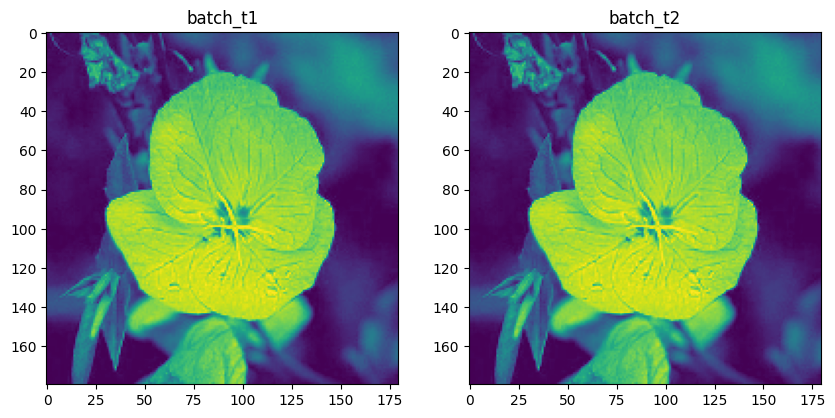

mini_dataloader  torch.Size([17, 2, 31, 31]) torch.Size([1, 3, 17])


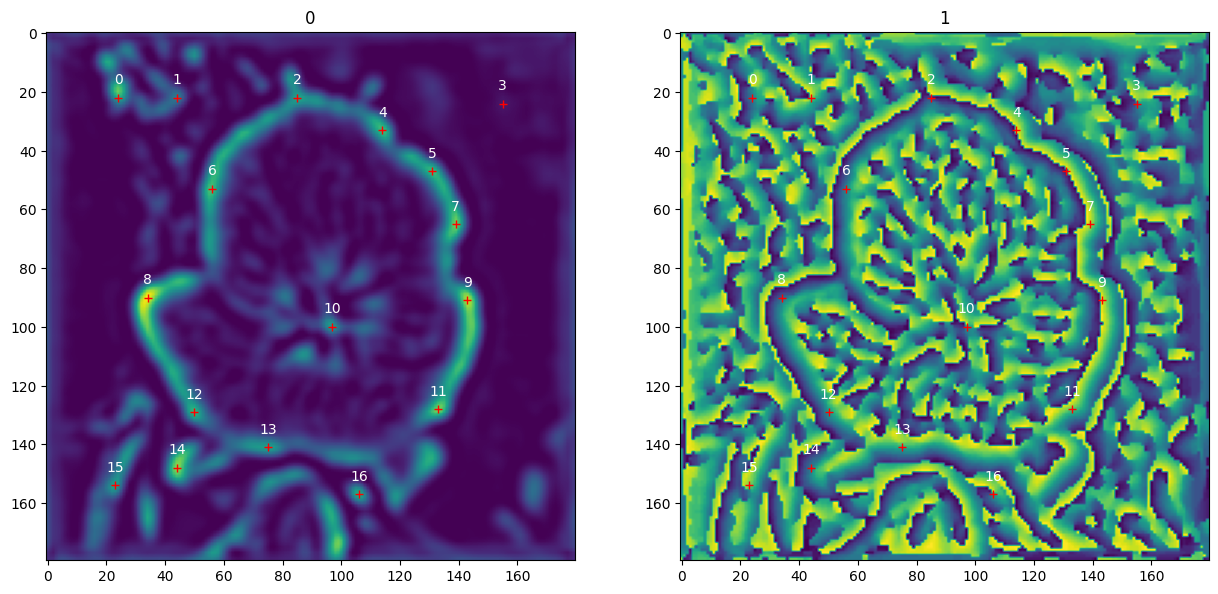

mini_dataloader  torch.Size([17, 2, 31, 31]) torch.Size([1, 17, 2])


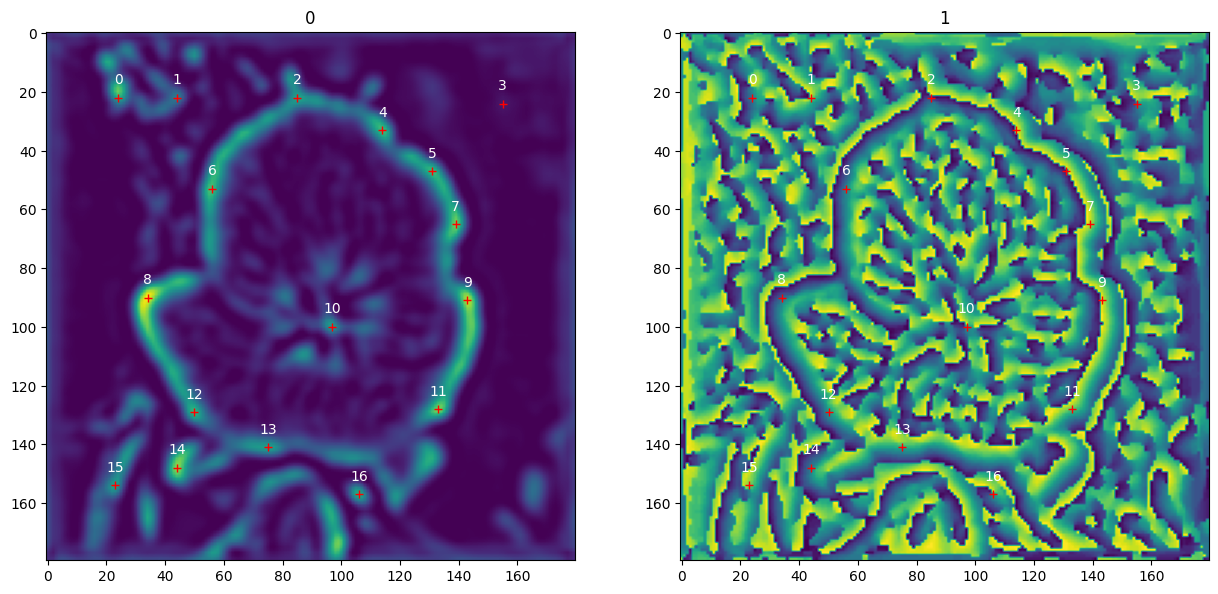

matching pair  (17, 2)


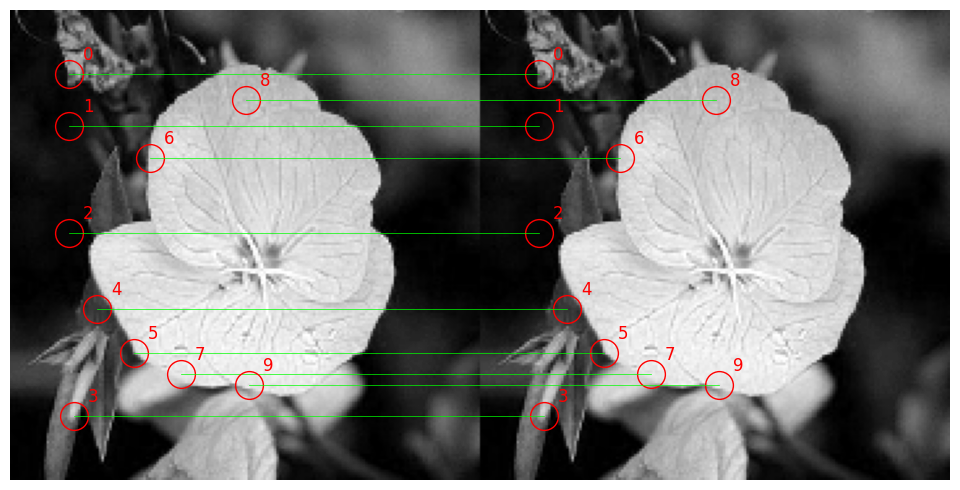

i  0  j  0


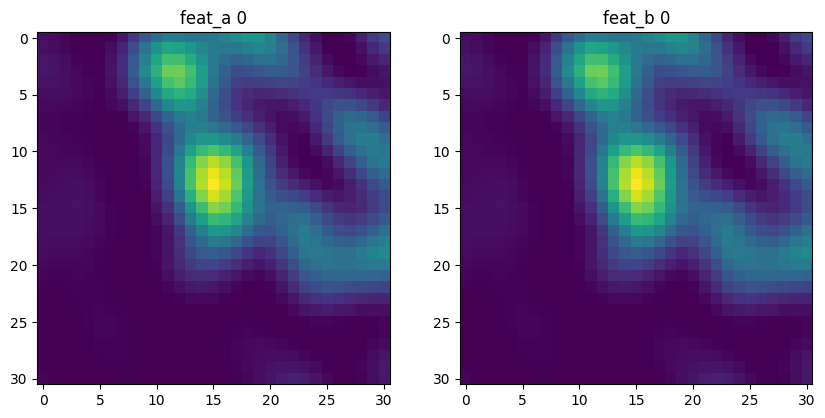

i  1  j  1


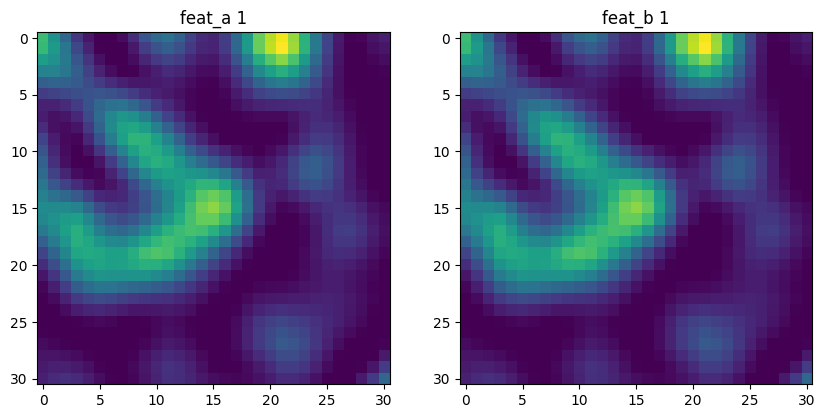

i  2  j  2


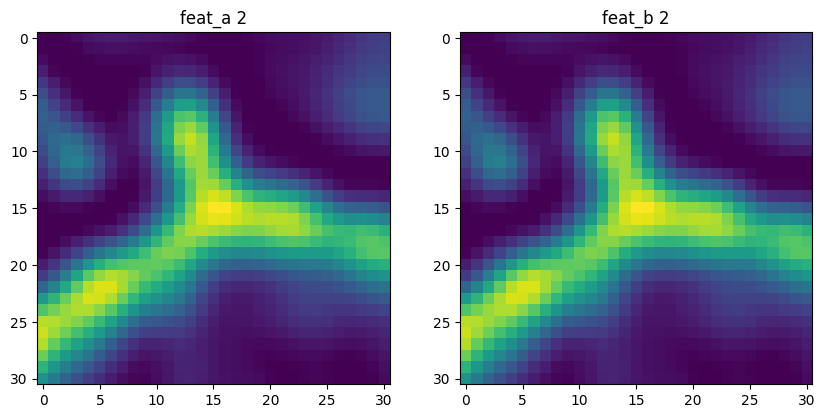

i  3  j  3


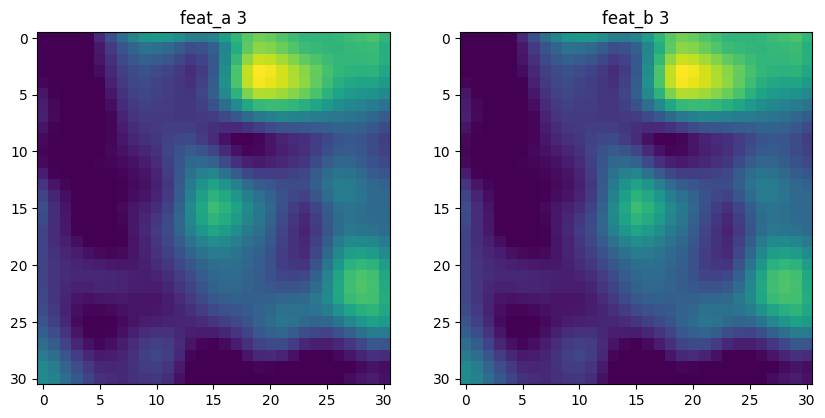

i  4  j  4


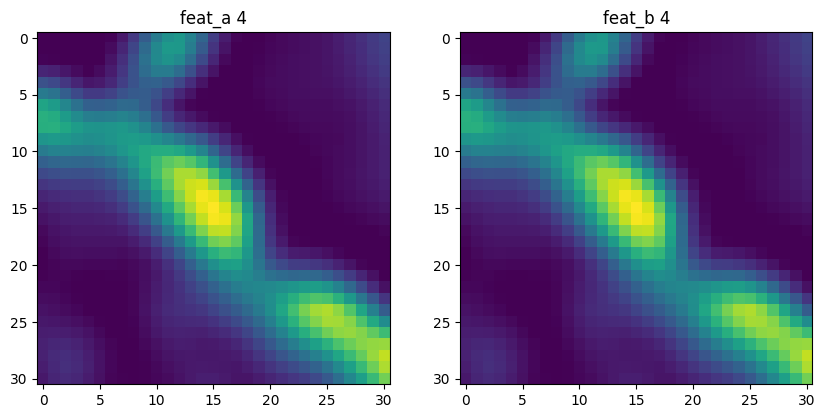

i  5  j  5


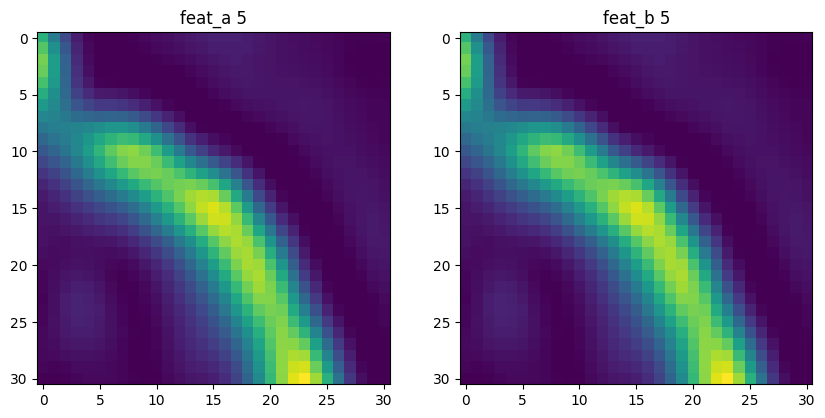

i  6  j  6


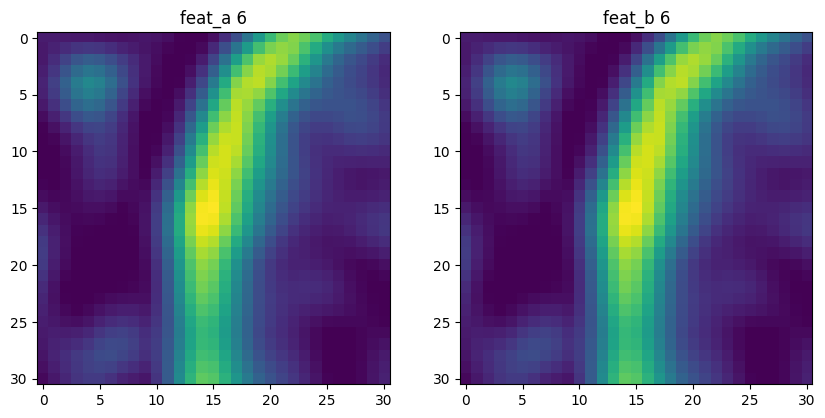

i  7  j  7


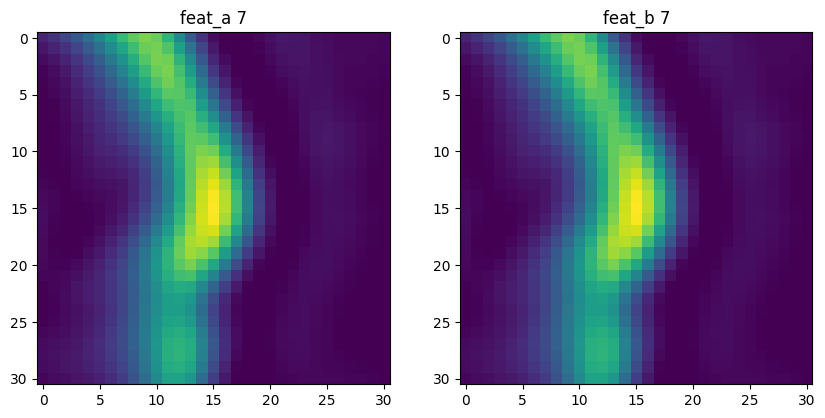

i  8  j  8


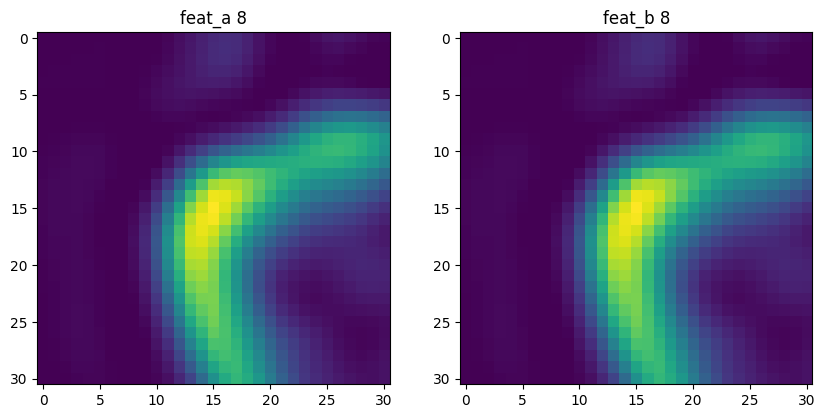

i  9  j  9


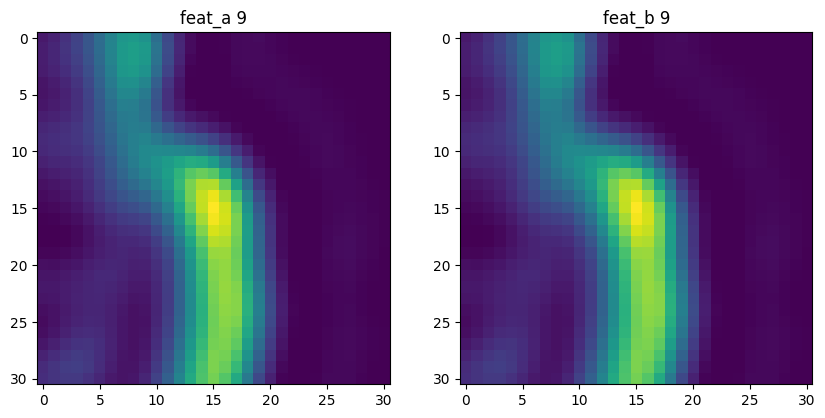

In [18]:
args.nms_size = 30


img_batch, labels =batch
print(len(img_batch),labels) #4

batch_t1 =(img_batch[:1],labels[:1])
img_batch1, labels1 =batch_t1
print(len(img_batch1),labels1) #1

#rotaciona batch_t1
img_batch2 = random_transform(img_batch1)
batch_t2 = (img_batch2,labels1)

plot_pair_image(img_batch1[0,0],img_batch2[0,0],'batch_t1','batch_t2')

#find single point of batch_t2 and batch_t1
feature_t1,orien_t1 = predict_single_points(single_point_model,batch_t1)
batch_result_t1,coords_t1 = extract_features_with_box(feature_t1,orien_t1)
mini_dataloader_t1 = concatenate_mini_batches_feat_orien(batch_result_t1)
points_t1 = coords_t1[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t1.shape,coords_t1.shape)

imshow2(feature_t1[0,0].cpu().detach(),orien_t1[0,0].cpu().detach(),coords_t1[0,:,:17])

feature_t2,orien_t2 = predict_single_points(single_point_model,batch_t2)
batch_result_t2,coords_t2 = extract_features_with_box(feature_t2,orien_t2)
mini_dataloader_t2 = concatenate_mini_batches_feat_orien(batch_result_t2)
points_t2 = coords_t2[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t2.shape,points_t2.shape)
imshow2(feature_t2[0,0].cpu().detach(),orien_t2[0,0].cpu().detach(),coords_t2[0,:,:17])


matching_results = matching_single_points(mini_dataloader_t1, mini_dataloader_t2, apply_random_transform=True)
print('matching pair ',matching_results.shape)
plot_matches(img_batch2[0,0], points_t2[0], img_batch1[0,0], points_t1[0], matching_results[:10])


for (i,j) in matching_results[:10]:
    print('i ',i,' j ',j)
    plot_pair_image(mini_dataloader_t2[i,0],mini_dataloader_t1[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

tensor(0., device='cuda:0') tensor(14.8837, device='cuda:0') tensor(1.2314, device='cuda:0')
tensor(0., device='cuda:0') tensor(14., device='cuda:0') tensor(0.9594, device='cuda:0')


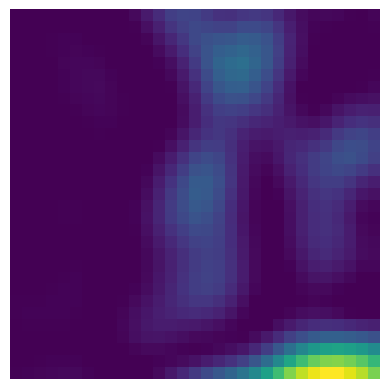

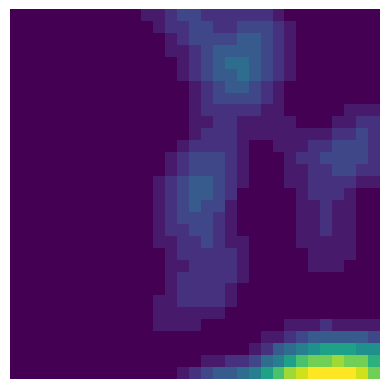

In [19]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Carregar a imagem em tons de cinza como um tensor
gray_image = data[5,0]

# Reduzir a quantidade de cores para 16
num_colors = 9
print(gray_image.min(),gray_image.max(),gray_image.mean())
quantized_image = torch.floor_divide(gray_image, 9 // num_colors) * (9 // num_colors)
print(quantized_image.min(),quantized_image.max(),quantized_image.mean())


plt.imshow(gray_image.cpu().numpy())
plt.axis('off')
plt.show()
# Mostrar a imagem quantizada
plt.imshow(quantized_image.cpu().numpy())
plt.axis('off')
plt.show()
